In [1]:
### ARCHITECTURE SEARCH : averaging psychophysical results across architectures ###
import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
import util_psychophysics_figures


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value


### Specify scope of all models to compare (regex must grab all model output directories)
regex_model_dir = '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_*/'
basename_valid_metrics = 'validation_metrics.json'
basename_arch_config = 'brain_arch.json'

### Specify results_dict basenames for each experiment
experiment_to_basename_map = {
    'bernox2005': 'EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json',
    'transposedtones': 'EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json',
    'freqshiftedcomplexes': 'EVAL_mooremoore2003_080to480Hz_bestckpt_results_dict.json',
    'mistunedharmonics': 'EVAL_MistunedHarm_v00_bestckpt_results_dict.json',
    'altphasecomplexes': 'EVAL_AltPhase_v01_bestckpt_results_dict.json',
}
for key in experiment_to_basename_map.keys():
    experiment_to_basename_map[key] = experiment_to_basename_map[key].replace('EVAL_', 'EVAL_SOFTMAX_')

### Build dictionary of human results_dict for each experiment
experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}

experiment_keys = [
    'bernox2005',
    'transposedtones',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'altphasecomplexes'
]
list_valid_metric = []
list_model_dir = []
disp_step = 100

for idx, model_dir in enumerate(sorted(glob.glob(regex_model_dir))):
    fn_valid_metric = os.path.join(model_dir, basename_valid_metrics)
    fn_arch_config = os.path.join(model_dir, basename_arch_config)
    fn_result_dict = {}
    for ek in experiment_keys:
        fn_result_dict[ek] = os.path.join(model_dir, experiment_to_basename_map[ek])
    
    include_model_flag = True
    if not os.path.exists(fn_arch_config): include_model_flag = False
    if not os.path.exists(fn_valid_metric): include_model_flag = False
    for ek in experiment_keys:
        if not os.path.exists(fn_result_dict[ek]): include_model_flag = False 
    
    if include_model_flag:
        list_model_dir.append(model_dir)
        list_valid_metric.append(calc_best_metric(fn_valid_metric))
    
    if idx % disp_step == 0:
        print(model_dir, include_model_flag)


/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0000/ False
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0100/ True
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0200/ True
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0300/ True
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0400/ True
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0500/ True
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0600/ True
/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_0700/ False


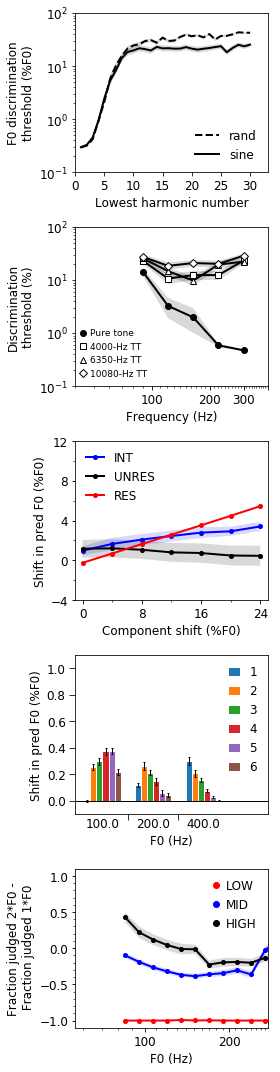

In [5]:
import importlib
importlib.reload(util_psychophysics_figures)

sort_idx = np.argsort(list_valid_metric)
sorted_list_valid_metric = np.array(list_valid_metric)[sort_idx]
sorted_list_model_dir = np.array(list_model_dir)[sort_idx]
top_model_dirs = sorted_list_model_dir[-50:]

experiment_keys = [
    'bernox2005',
    'transposedtones',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'altphasecomplexes'
]

experiment_to_plot_fcn_map = {
    'bernox2005': util_psychophysics_figures.make_bernox_threshold_plot,
    'transposedtones': util_psychophysics_figures.make_TT_threshold_plot,
    'freqshiftedcomplexes': util_psychophysics_figures.make_freqshiftedcomplexes_plot,
    'mistunedharmonics': util_psychophysics_figures.make_mistuned_harmonics_bar_graph,
    'altphasecomplexes': util_psychophysics_figures.make_altphase_plot,
}


results_dicts = {key: [] for key in experiment_keys}
for key in experiment_keys:
    for model_dir in top_model_dirs:
        results_dict_fn = os.path.join(model_dir, experiment_to_basename_map[key])
#         print(results_dict_fn)
        with open(results_dict_fn) as f:
            results_dicts[key].append(json.load(f))

NROWS = len(experiment_keys)
NCOLS = 1
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))

for ax_idx, key in enumerate(experiment_keys):
    plot_fcn = experiment_to_plot_fcn_map[key]
    kwargs = {'include_yerr': True}
    if ('bernox' in key) or ('transposed' in key):
        kwargs['threshold_cap'] = 50.0
    plot_fcn(ax[ax_idx], results_dicts[key], **kwargs)

plt.tight_layout()
plt.show()


546


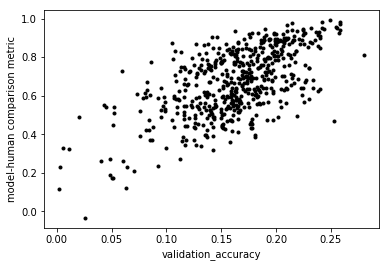

(0.6239044978820033, 3.0983431556806343e-60)


In [1]:
### ARCHITECTURE SEARCH : bernox2005 ###

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
human_results_dict = util_human_model_comparison.get_human_results_dict_bernox2005(average_conditions=True)


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value

def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


results_dict_regex = '/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json'
results_dict_fn_list = sorted(glob.glob(results_dict_regex))
valid_dict_fn_list = []
arch_dict_fn_list = []
for fn in results_dict_fn_list:
    output_dir, _ = os.path.split(fn)
    valid_dict_fn_list.append(os.path.join(output_dir, 'validation_metrics.json'))
    arch_dict_fn_list.append(os.path.join(output_dir, 'brain_arch.json'))

results_dict_list = []
valid_metric_list = []
arch_stat_list = []
human_comparison_metric_list = []
for idx, (rdfn, vfn, afn) in enumerate(zip(results_dict_fn_list, valid_dict_fn_list, arch_dict_fn_list)):
    results_dict = load_results_dict(rdfn)
    results_dict_list.append(results_dict)
    valid_metric_list.append(calc_best_metric(vfn))
    arch_stat_list.append(calc_num_layers(afn))
    
    (corr_value, pval) = util_human_model_comparison.compare_bernox2005(
        human_results_dict, results_dict,
        kwargs_interp={}, kwargs_compare={'log_scale':True, 'metric':'spearmanr'})
    
    human_comparison_metric_list.append(corr_value)
    

print(len(results_dict_list))

plt.figure()
plt.plot(valid_metric_list, human_comparison_metric_list, 'k.')
plt.xlabel('validation_accuracy')
plt.ylabel('model-human comparison metric')
plt.show()

import scipy.stats
print(scipy.stats.pearsonr(valid_metric_list, human_comparison_metric_list))


generating 54 plots


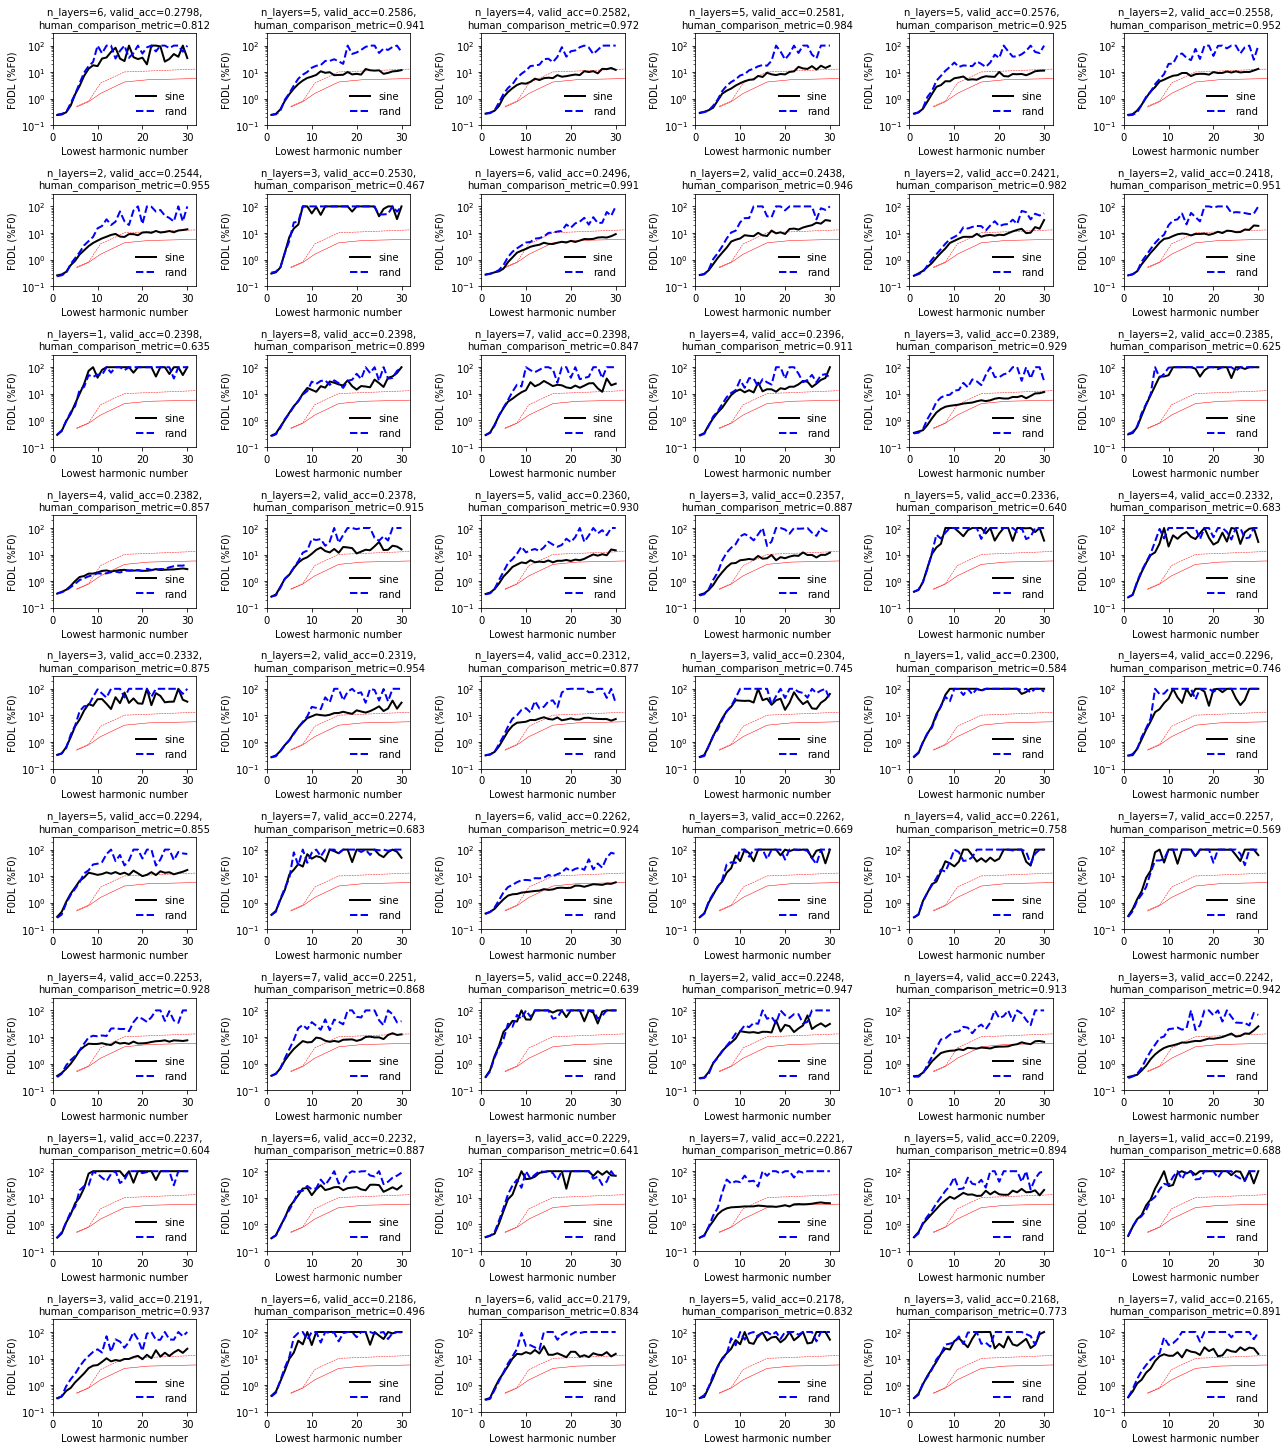

In [4]:
### MAKE PLOTS : bernox2005 ###

tmp_valid_metric_list = valid_metric_list.copy()
tmp_arch_stat_list = arch_stat_list.copy()
sort_idx = np.flip(np.argsort(valid_metric_list)).tolist()
# sort_idx = np.flip(np.argsort(human_comparison_metric_list)).tolist()

model_idx_list = []
for idx in sort_idx:
    if True: #human_comparison_metric_list[idx] < 0.9:#tmp_arch_stat_list[idx] == 6:
        model_idx_list.append(idx)
        
model_idx_list = model_idx_list[0:54]
print('generating {} plots'.format(len(model_idx_list)))

#for idx in model_idx_list: print(arch_dict_fn_list[idx])


def make_threshold_plot(ax, results_dict, title_str=None, legend_on=True,
                        sine_plot_kwargs={}, rand_plot_kwargs={},
                        xlabel='Lowest harmonic number',
                        ylabel='F0 discrimination threshold (%F0)'):
    phase_mode_list = np.array(results_dict['phase_mode'])
    low_harm_list = np.array(results_dict['low_harm'])
    f0dl_list = np.array(results_dict['f0dl'])
    CAP = 100.0
    f0dl_list[f0dl_list > CAP] = CAP
    unique_phase_modes = np.unique(phase_mode_list)
    for phase_mode in unique_phase_modes:
        x = low_harm_list[phase_mode_list == phase_mode]
        y = f0dl_list[phase_mode_list == phase_mode]
        
        if phase_mode == 0:
            plot_kwargs = {'label': 'sine', 'color': 'b', 'ls':'-', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(sine_plot_kwargs)
        else:
            plot_kwargs = {'label': 'rand', 'color': 'b', 'ls':'--', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(rand_plot_kwargs)
        
        if not legend_on: plot_kwargs['label'] = None
        ax.plot(x, y, **plot_kwargs)

    ax.set_yscale('log')
    ax.set_ylim([1e-1, 3e2])
    ax.set_xlim([0, 32])
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    if title_str is not None: ax.set_title(title_str, fontsize=10)
    if legend_on: ax.legend(loc='lower right', frameon=False, fontsize=10)



NCOLS = 6
NROWS = int(np.ceil(len(model_idx_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(0.75*4*NCOLS, 0.75*3*NROWS))
ax_arr = ax_arr.flatten()

for ax_idx, model_idx in enumerate(model_idx_list):
    
    results_dict = results_dict_list[model_idx]
    
    title_str = 'n_layers={:d}, valid_acc={:.4f},\nhuman_comparison_metric={:.3f}'.format(
        arch_stat_list[model_idx],
        valid_metric_list[model_idx],
        human_comparison_metric_list[model_idx])
    
    ax = ax_arr[ax_idx]
    make_threshold_plot(ax, human_results_dict, title_str=None, legend_on=False,
                        sine_plot_kwargs={'color':'r', 'lw':0.5}, rand_plot_kwargs={'color':'r', 'lw':0.5})
    make_threshold_plot(ax, results_dict, title_str=title_str, legend_on=True,
                        sine_plot_kwargs={'color':'k', 'lw':2}, rand_plot_kwargs={'color':'b', 'lw':2},
                        ylabel='F0DL (%F0)')

for ax_idx in range(len(model_idx_list), len(ax_arr)): ax_arr[ax_idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/archive_2019_10_05_archSearch00_parameterAnalysis/2019OCT03_arch_search_v00_bernox2005_top54_byValidAcc.pdf', bbox_inches='tight')



In [ ]:
### ARCHITECTURE SEARCH : transposed tones ###

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
human_results_dict = util_human_model_comparison.get_human_results_dict_transposedtones()


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value

def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


results_dict_regex = '/om/scratch/Sun/msaddler/pitchnet/saved_models/arch_search_v00/arch_*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json'
results_dict_fn_list = sorted(glob.glob(results_dict_regex))
valid_dict_fn_list = []
arch_dict_fn_list = []
for fn in results_dict_fn_list:
    output_dir, _ = os.path.split(fn)
    valid_dict_fn_list.append(os.path.join(output_dir, 'validation_metrics.json'))
    arch_dict_fn_list.append(os.path.join(output_dir, 'brain_arch.json'))

results_dict_list = []
valid_metric_list = []
arch_stat_list = []
human_comparison_metric_list = []
for idx, (rdfn, vfn, afn) in enumerate(zip(results_dict_fn_list, valid_dict_fn_list, arch_dict_fn_list)):
    results_dict = load_results_dict(rdfn)
    results_dict_list.append(results_dict)
    valid_metric_list.append(calc_best_metric(vfn))
    arch_stat_list.append(calc_num_layers(afn))
    
    (corr_value, pval) = util_human_model_comparison.compare_transposedtones(
        human_results_dict, results_dict,
        kwargs_interp={}, kwargs_compare={'log_scale':True, 'metric':'spearmanr'})
    
    human_comparison_metric_list.append(corr_value)
    

print(len(results_dict_list))

plt.figure()
plt.plot(valid_metric_list, human_comparison_metric_list, 'k.')
plt.xlabel('validation_accuracy')
plt.ylabel('model-human comparison metric')
plt.show()

import scipy.stats
print(scipy.stats.pearsonr(valid_metric_list, human_comparison_metric_list))


In [ ]:
### MAKE PLOTS : transposed tones ###

tmp_valid_metric_list = valid_metric_list.copy()
tmp_arch_stat_list = arch_stat_list.copy()
sort_idx = np.flip(np.argsort(valid_metric_list)).tolist()
# sort_idx = np.flip(np.argsort(human_comparison_metric_list)).tolist()

model_idx_list = []
for idx in sort_idx:
    if tmp_arch_stat_list[idx] == 6:
        model_idx_list.append(idx)
print('generating {} plots'.format(len(model_idx_list)))


def make_TT_threshold_plot(ax, results_dict, title_str=None, legend_on=True):
    f0_ref = np.array(results_dict['f0_ref'])
    f_carrier_list = np.array(results_dict['f_carrier'])
    f0dl_list = np.array(results_dict['f0dl'])
    unique_f_carrier_list = np.unique(f_carrier_list)
    for f_carrier in unique_f_carrier_list:
        x = f0_ref[f_carrier_list == f_carrier]
        y = f0dl_list[f_carrier_list == f_carrier]
        
        if f_carrier > 0:
            label = '{}-Hz TT'.format(int(f_carrier))
            plot_kwargs = {'label': label, 'color': 'k', 'ls':'-', 'lw':2, 'ms':6,
                           'marker':'o', 'markerfacecolor': 'w'}
            if int(f_carrier) == 10080: plot_kwargs['marker'] = 'D'
            if int(f_carrier) == 6350: plot_kwargs['marker'] = '^'
            if int(f_carrier) == 4000: plot_kwargs['marker'] = 's'
        else:
            label = 'Pure tone'
            plot_kwargs = {'label': label, 'color': 'k', 'ls':'-', 'lw':2, 'ms':6,
                           'marker':'o', 'markerfacecolor': 'k'}
            
        if not legend_on: plot_kwargs['label'] = None
        ax.plot(x, y, **plot_kwargs)

    ax.set_yscale('log')
    ax.set_ylim([5e-1, 3e1])
    ax.set_xscale('log')
    ax.set_xlim([40, 500])
    ax.set_xlabel('Frequency (Hz)', fontsize=10)
    ax.set_ylabel('Frequency difference (%)', fontsize=10)
    if title_str is not None: ax.set_title(title_str, fontsize=10)
    if legend_on: ax.legend(loc='lower left', frameon=False, fontsize=8, handlelength=0)


        
NCOLS = 6
NROWS = int(np.ceil(len(model_idx_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(0.75*4*NCOLS, 0.75*3*NROWS))
ax_arr = ax_arr.flatten()

for ax_idx, model_idx in enumerate(model_idx_list):
    
    results_dict = results_dict_list[model_idx]
    
    title_str = 'n_layers={:d}, valid_acc={:.4f},\nhuman_comparison_metric={:.3f}'.format(
        arch_stat_list[model_idx],
        valid_metric_list[model_idx],
        human_comparison_metric_list[model_idx])
    
    ax = ax_arr[ax_idx]
    make_TT_threshold_plot(ax, results_dict, title_str=title_str, legend_on=True)

for ax_idx in range(len(model_idx_list), len(ax_arr)): ax_arr[ax_idx].axis('off')

plt.tight_layout()
plt.show()



In [ ]:
### ARCHITECTURE SEARCH : freq-shifted complexes ###

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
human_results_dict = util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes()


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value

def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


results_dict_regex = '/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v00/arch_*/EVAL_mooremoore2003_080to480Hz_bestckpt_results_dict.json'
results_dict_fn_list = sorted(glob.glob(results_dict_regex))
valid_dict_fn_list = []
arch_dict_fn_list = []
for fn in results_dict_fn_list:
    output_dir, _ = os.path.split(fn)
    valid_dict_fn_list.append(os.path.join(output_dir, 'validation_metrics.json'))
    arch_dict_fn_list.append(os.path.join(output_dir, 'brain_arch.json'))

results_dict_list = []
valid_metric_list = []
arch_stat_list = []
human_comparison_metric_list = []
for idx, (rdfn, vfn, afn) in enumerate(zip(results_dict_fn_list, valid_dict_fn_list, arch_dict_fn_list)):
    results_dict = load_results_dict(rdfn)
    results_dict_list.append(results_dict)
    valid_metric_list.append(calc_best_metric(vfn))
    arch_stat_list.append(calc_num_layers(afn))
    
    (corr_value, pval) = util_human_model_comparison.compare_freqshiftedcomplexes(
        human_results_dict, results_dict,
        kwargs_interp={}, kwargs_compare={'log_scale':False, 'metric':'pearsonr'})
    
    human_comparison_metric_list.append(corr_value)
    

print(len(results_dict_list))

plt.figure()
plt.plot(valid_metric_list, human_comparison_metric_list, 'k.')
plt.xlabel('validation_accuracy')
plt.ylabel('model-human comparison metric')
plt.show()

import scipy.stats
print(scipy.stats.pearsonr(valid_metric_list, human_comparison_metric_list))

In [ ]:
### MAKE PLOTS : freq-shifted complexes ###

tmp_valid_metric_list = valid_metric_list.copy()
tmp_arch_stat_list = arch_stat_list.copy()
sort_idx = np.flip(np.argsort(valid_metric_list)).tolist()
# sort_idx = np.flip(np.argsort(human_comparison_metric_list)).tolist()

model_idx_list = []
for idx in sort_idx:
    if tmp_arch_stat_list[idx] == 6:
        model_idx_list.append(idx)
print('generating {} plots'.format(len(model_idx_list)))


def make_freqshiftedcomplexes_plot(ax, results_dict, title_str=None, legend_on=True):
    key_to_label_map={5:'RES', 11:'INT', 16:'UNRES'}
    filter_key='spectral_envelope_centered_harmonic'
    for key in sorted(results_dict[filter_key].keys()):
        xval = results_dict[filter_key][key]['f0_shift']
        yval = results_dict[filter_key][key]['f0_pred_shift_median']
        yerr = results_dict[filter_key][key]['f0_pred_shift_stddev']
        ax.plot(xval, yval, '.-', label=key_to_label_map.get(key, key))

    if legend_on: ax.legend(loc=2, frameon=False, fontsize=10)
    if title_str: ax.set_title(title_str, fontsize=10)
    ax.set_xlabel('Component shift (%F0)', fontsize=10)
    ax.set_ylabel('Shift in pred F0 (%F0)', fontsize=10)
    ax.set_xlim([-0.5, 24.5])
    ax.set_ylim([-4, 12])



NCOLS = 6
NROWS = int(np.ceil(len(model_idx_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(0.75*4*NCOLS, 0.75*3*NROWS))
ax_arr = ax_arr.flatten()

for ax_idx, model_idx in enumerate(model_idx_list):
    
    results_dict = results_dict_list[model_idx]
    
    title_str = 'n_layers={:d}, valid_acc={:.4f},\nhuman_comparison_metric={:.3f}'.format(
        arch_stat_list[model_idx],
        valid_metric_list[model_idx],
        human_comparison_metric_list[model_idx])
    
    ax = ax_arr[ax_idx]
    make_freqshiftedcomplexes_plot(ax, results_dict, title_str=title_str, legend_on=True)

for ax_idx in range(len(model_idx_list), len(ax_arr)): ax_arr[ax_idx].axis('off')

plt.tight_layout()
plt.show()



In [ ]:
### ARCHITECTURE SEARCH : mistuned harmonics ###

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
human_results_dict = util_human_model_comparison.get_human_results_dict_mistunedharmonics()


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value

def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


results_dict_regex = '/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v00/arch_*/EVAL_MistunedHarm_v00_bestckpt_results_dict.json'
results_dict_fn_list = sorted(glob.glob(results_dict_regex))
valid_dict_fn_list = []
arch_dict_fn_list = []
for fn in results_dict_fn_list:
    output_dir, _ = os.path.split(fn)
    valid_dict_fn_list.append(os.path.join(output_dir, 'validation_metrics.json'))
    arch_dict_fn_list.append(os.path.join(output_dir, 'brain_arch.json'))

results_dict_list = []
valid_metric_list = []
arch_stat_list = []
human_comparison_metric_list = []
for idx, (rdfn, vfn, afn) in enumerate(zip(results_dict_fn_list, valid_dict_fn_list, arch_dict_fn_list)):
    results_dict = load_results_dict(rdfn)
    results_dict_list.append(results_dict)
    valid_metric_list.append(calc_best_metric(vfn))
    arch_stat_list.append(calc_num_layers(afn))
    
    (corr_value, pval) = util_human_model_comparison.compare_mistunedharmonics(
        human_results_dict, results_dict,
        kwargs_bar_graph={}, kwargs_compare={'log_scale':False, 'metric':'pearsonr'})
    
    human_comparison_metric_list.append(corr_value)
    

print(len(results_dict_list))

plt.figure()
plt.plot(valid_metric_list, human_comparison_metric_list, 'k.')
plt.xlabel('validation_accuracy')
plt.ylabel('model-human comparison metric')
plt.show()

import scipy.stats
print(scipy.stats.pearsonr(valid_metric_list, human_comparison_metric_list))


In [ ]:
### MAKE PLOTS : mistuned harmonics ###

tmp_valid_metric_list = valid_metric_list.copy()
tmp_arch_stat_list = arch_stat_list.copy()
sort_idx = np.flip(np.argsort(valid_metric_list)).tolist()
# sort_idx = np.flip(np.argsort(human_comparison_metric_list)).tolist()

model_idx_list = []
for idx in sort_idx:
    if tmp_arch_stat_list[idx] == 6:
        model_idx_list.append(idx)
print('generating {} plots'.format(len(model_idx_list)))


def make_mistuned_harmonics_bar_graph(ax, results_dict, mistuned_pct=3.0,
                                      pitch_shift_key='f0_pred_pct_median',
                                      title_str=None, legend_on=True, barwidth=0.12):
    '''
    '''
    bar_graph_results_dict = util_human_model_comparison.get_mistuned_harmonics_bar_graph_results_dict(
        results_dict,
        mistuned_pct=mistuned_pct,
        pitch_shift_key=pitch_shift_key,
        harmonic_list=[1,2,3,4,5,6])

    num_groups = len(bar_graph_results_dict.keys())
    group_xoffsets = np.arange(num_groups) - np.mean(np.arange(num_groups))
    
    for group_idx, group_key in enumerate(sorted(bar_graph_results_dict.keys())):
        bars_per_group = len(bar_graph_results_dict[group_key]['f0_ref'])
        xvals = np.arange(bars_per_group)
        yvals = np.array(bar_graph_results_dict[group_key][pitch_shift_key])
        
        xvals = xvals + barwidth*group_xoffsets[group_idx]
        ax.bar(xvals, yvals, width=barwidth, edgecolor='white', label=group_key)

    base_xvals = np.arange(bars_per_group)
    f0_ref_values = bar_graph_results_dict[group_key]['f0_ref']
    
    if title_str: ax.set_title(title_str, fontsize=10)
    if legend_on: ax.legend(loc='upper right', frameon=False, fontsize=8, handlelength=0.5)
    ax.set_xlim([barwidth*group_xoffsets[0]-0.5,
                 np.max(base_xvals) + barwidth*group_xoffsets[-1] + 1])
    ax.set_xlabel('F0 (Hz)')
    ax.set_xticks(base_xvals)
    ax.set_xticklabels(f0_ref_values)



NCOLS = 6
NROWS = int(np.ceil(len(model_idx_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(0.75*4*NCOLS, 0.75*3*NROWS))
ax_arr = ax_arr.flatten()

for ax_idx, model_idx in enumerate(model_idx_list):
    
    results_dict = results_dict_list[model_idx]
    
    title_str = 'n_layers={:d}, valid_acc={:.4f},\nhuman_comparison_metric={:.3f}'.format(
        arch_stat_list[model_idx],
        valid_metric_list[model_idx],
        human_comparison_metric_list[model_idx])
    
    ax = ax_arr[ax_idx]
    make_mistuned_harmonics_bar_graph(ax, results_dict, mistuned_pct=3.0,
                                      pitch_shift_key='f0_pred_pct_median',
                                      title_str=title_str, legend_on=True, barwidth=0.12)

for ax_idx in range(len(model_idx_list), len(ax_arr)): ax_arr[ax_idx].axis('off')

plt.tight_layout()
plt.show()



In [ ]:
### ARCHITECTURE SEARCH : alt-phase complexes ###

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
human_results_dict = util_human_model_comparison.get_human_results_dict_altphasecomplexes()


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value

def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


results_dict_regex = '/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v00/arch_*/EVAL_AltPhase_v01_bestckpt_results_dict.json'
results_dict_fn_list = sorted(glob.glob(results_dict_regex))
valid_dict_fn_list = []
arch_dict_fn_list = []
for fn in results_dict_fn_list:
    output_dir, _ = os.path.split(fn)
    valid_dict_fn_list.append(os.path.join(output_dir, 'validation_metrics.json'))
    arch_dict_fn_list.append(os.path.join(output_dir, 'brain_arch.json'))

results_dict_list = []
valid_metric_list = []
arch_stat_list = []
human_comparison_metric_list = []
for idx, (rdfn, vfn, afn) in enumerate(zip(results_dict_fn_list, valid_dict_fn_list, arch_dict_fn_list)):
    results_dict = load_results_dict(rdfn)
    results_dict_list.append(results_dict)
    valid_metric_list.append(calc_best_metric(vfn))
    arch_stat_list.append(calc_num_layers(afn))
    
    (corr_value, pval) = util_human_model_comparison.compare_altphasecomplexes(
        human_results_dict, results_dict,
        kwargs_interp={}, kwargs_compare={'log_scale':False, 'metric': 'spearmanr'})
    
    human_comparison_metric_list.append(corr_value)
    

print(len(results_dict_list))

plt.figure()
plt.plot(valid_metric_list, human_comparison_metric_list, 'k.')
plt.xlabel('validation_accuracy')
plt.ylabel('model-human comparison metric')
plt.show()

import scipy.stats
print(scipy.stats.pearsonr(valid_metric_list, human_comparison_metric_list))


In [ ]:
### MAKE PLOTS : alt-phase complexes ###

tmp_valid_metric_list = valid_metric_list.copy()
tmp_arch_stat_list = arch_stat_list.copy()
# sort_idx = np.flip(np.argsort(valid_metric_list)).tolist()
sort_idx = np.flip(np.argsort(human_comparison_metric_list)).tolist()

model_idx_list = []
for idx in sort_idx:
    if tmp_arch_stat_list[idx] == 6:
        model_idx_list.append(idx)
        
print('generating {} plots'.format(len(model_idx_list)))


def make_altphase_plot(ax, results_dict, title_str=None, legend_on=True):
    
    for key in sorted(results_dict['filter_fl_bin_means'].keys()):
        ax.plot(results_dict['f0_bin_centers'], results_dict['filter_fl_bin_means'][key], 'o-', label=key)
    
    if legend_on: ax.legend(loc=0, frameon=False, handlelength=2, markerscale=0, fontsize=8)
    if title_str: ax.set_title(title_str, fontsize=10)
    ax.set_xscale('log')



NCOLS = 6
NROWS = int(np.ceil(len(model_idx_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(0.75*4*NCOLS, 0.75*3*NROWS))
ax_arr = ax_arr.flatten()

for ax_idx, model_idx in enumerate(model_idx_list):
    
    results_dict = results_dict_list[model_idx]
    
    title_str = 'n_layers={:d}, valid_acc={:.4f},\nhuman_comparison_metric={:.3f}'.format(
        arch_stat_list[model_idx],
        valid_metric_list[model_idx],
        human_comparison_metric_list[model_idx])
    
    ax = ax_arr[ax_idx]
    make_altphase_plot(ax, results_dict, title_str=title_str, legend_on=True)
#     make_altphase_plot(ax, human_results_dict, title_str=None, legend_on=False)

for ax_idx in range(len(model_idx_list), len(ax_arr)): ax_arr[ax_idx].axis('off')

plt.tight_layout()
plt.show()



In [3]:
import sys
import os
import json
import numpy as np
import scipy.stats
import glob
import importlib
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
import util_psychophysics_figures
importlib.reload(util_psychophysics_figures)


### Specify scope of all models to compare (regex must grab all model output directories)
regex_model_dir = '/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_*/'
basename_valid_metrics = 'validation_metrics.json'
basename_arch_config = 'brain_arch.json'

### Specify results_dict basenames for each experiment
experiment_to_basename_map = {
    'bernox2005': 'EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json',
    'transposedtones': 'EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json',
    'freqshiftedcomplexes': 'EVAL_mooremoore2003_080to480Hz_bestckpt_results_dict.json',
    'mistunedharmonics': 'EVAL_MistunedHarm_v00_bestckpt_results_dict.json',
    'altphasecomplexes': 'EVAL_AltPhase_v01_bestckpt_results_dict.json',
}

### Build dictionary of human results_dict for each experiment
experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}

### Build dictionary of human results_dict vs. model results_dict comparison functions
experiment_to_compfunc_map = {
    'bernox2005': lambda x1, x2: util_human_model_comparison.compare_bernox2005(
        x1, x2, kwargs_interp={}, kwargs_compare={'log_scale':True, 'metric':'spearmanr'}),
    'transposedtones': lambda x1, x2: util_human_model_comparison.compare_transposedtones(
        x1, x2, kwargs_interp={}, kwargs_compare={'log_scale':True, 'metric':'spearmanr'}),
    'freqshiftedcomplexes': lambda x1, x2: util_human_model_comparison.compare_freqshiftedcomplexes(
        x1, x2, kwargs_interp={}, kwargs_compare={'log_scale':False, 'metric':'spearmanr'}),
    'mistunedharmonics': lambda x1, x2: util_human_model_comparison.compare_mistunedharmonics(
        x1, x2, kwargs_compare={'log_scale':False, 'metric':'spearmanr'}),
    'altphasecomplexes': lambda x1, x2: util_human_model_comparison.compare_altphasecomplexes(
        x1, x2, kwargs_interp={}, kwargs_compare={'log_scale':False, 'metric':'spearmanr'}),
}


In [4]:
def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value


experiment_keys = [
    'bernox2005',
    'transposedtones',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'altphasecomplexes'
]
list_arch_dict = []
list_valid_metric = []
list_human_comparison_dict = {ek:[] for ek in experiment_keys}
list_model_dir = sorted(glob.glob(regex_model_dir))
disp_step = 50

for idx, model_dir in enumerate(list_model_dir):
    
    fn_valid_metric = os.path.join(model_dir, basename_valid_metrics)
    fn_arch_config = os.path.join(model_dir, basename_arch_config)
    fn_result_dict = {}
    for ek in experiment_keys:
        fn_result_dict[ek] = os.path.join(model_dir, experiment_to_basename_map[ek])
    
    include_model_flag = True
    if not os.path.exists(fn_arch_config): include_model_flag = False
    if not os.path.exists(fn_valid_metric): include_model_flag = False
    for ek in experiment_keys:
        if not os.path.exists(fn_result_dict[ek]): include_model_flag = False 
    
    if include_model_flag:
        with open(fn_arch_config) as f: arch_dict = json.load(f)
        list_arch_dict.append(arch_dict)
        list_valid_metric.append(calc_best_metric(fn_valid_metric))
        for ek in experiment_keys:
            human_results_dict = experiment_to_human_results_map[ek]
            results_dict = load_results_dict(fn_result_dict[ek])
            comparison_metric = experiment_to_compfunc_map[ek](human_results_dict, results_dict)
            if len(comparison_metric) == 2:
                comparison_metric = comparison_metric[0]
            list_human_comparison_dict[ek].append(comparison_metric)
    
    if idx % disp_step == 0:
        print(model_dir, include_model_flag)


/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_0000/ False
/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_0050/ True
/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_0100/ True
/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_0150/ False
/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_0200/ True
/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_0250/ True
/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_0300/ True
/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_0350/ True
/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_0400/ True
/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_0450/ True
/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_0500/ True
/om/scratch/Thu/msaddler/pitchnet/saved_models/arch_search_v00/arch_0550/ True
/om/scratch/Thu/msaddler/pitchnet/saved_models/arc

In [5]:
def combine_human_comparison_metrics(list_human_comparison_dict,
                                     experiment_keys=None):
    if experiment_keys is None:
        experiment_keys = list(list_human_comparison_dict.keys())
    combined_rankings = np.zeros_like(list_human_comparison_dict[experiment_keys[0]])
    for ek in experiment_keys:
        ek_sort_idx = np.argsort(list_human_comparison_dict[ek])
        ek_rankings = np.empty_like(ek_sort_idx)
        ek_rankings[ek_sort_idx] = np.arange(0, len(ek_sort_idx))
        combined_rankings = combined_rankings + ek_rankings
    return combined_rankings / len(experiment_keys)


def compute_architecture_stats(arch_dict):
    arch_stats = {
        'num_conv_layers': 0,
        'num_pool_layers': 0,
        'num_total_layers': 0,
        
        'sum_conv_kernel_dim_freqtimefilt': 0,
        'sum_conv_kernel_dim_freqtime': 0,
        'sum_conv_kernel_dim_freq': 0,
        'sum_conv_kernel_dim_time': 0,
        'sum_conv_kernel_dim_filt': 0,
        'max_conv_kernel_dim_freqtimefilt': 0,
        'max_conv_kernel_dim_freqtime': 0,
        'max_conv_kernel_dim_freq': 0,
        'max_conv_kernel_dim_time': 0,
        'max_conv_kernel_dim_filt': 0,
        
        'mul_pool_stride_dim_freqtime': 1,
        'mul_pool_stride_dim_freq': 1,
        'mul_pool_stride_dim_time': 1,
        'max_pool_stride_dim_freqtime': 0,
        'max_pool_stride_dim_freq': 0,
        'max_pool_stride_dim_time': 0,
        
        'layer0_conv_kernel_dim_freqtimefilt': 0,
        'layer0_conv_kernel_dim_freqtime': 0,
        'layer0_conv_kernel_dim_freq': 0,
        'layer0_conv_kernel_dim_time': 0,
        'layer0_conv_kernel_dim_filt': 0,
        
        'layer0_pool_stride_dim_freqtime': 0,
        'layer0_pool_stride_dim_freq': 0,
        'layer0_pool_stride_dim_time': 0,
        
        'largest_bottleneck': 10,
    }
    
    num_filters_list = []
    
    for layer in arch_dict:
        arch_stats['num_total_layers'] += 1
        if 'conv2d' in layer['layer_type']:
            arch_stats['num_conv_layers'] += 1
            [kernel_dim_freq, kernel_dim_time] = layer['args']['kernel_size']
            kernel_dim_filt = layer['args']['filters']
            kernel_dim_freqtime = kernel_dim_freq * kernel_dim_time
            kernel_dim_freqtimefilt = kernel_dim_freq * kernel_dim_time * kernel_dim_filt
            
            num_filters_list.append(kernel_dim_filt)
            
            arch_stats['sum_conv_kernel_dim_freqtimefilt'] += kernel_dim_freqtimefilt
            arch_stats['sum_conv_kernel_dim_freqtime'] += kernel_dim_freqtime
            arch_stats['sum_conv_kernel_dim_freq'] += kernel_dim_freq
            arch_stats['sum_conv_kernel_dim_time'] += kernel_dim_time
            arch_stats['sum_conv_kernel_dim_filt'] += kernel_dim_filt
            
            arch_stats['max_conv_kernel_dim_freqtimefilt'] = max(arch_stats['max_conv_kernel_dim_freqtimefilt'],
                                                             kernel_dim_freqtimefilt)
            arch_stats['max_conv_kernel_dim_freqtime'] = max(arch_stats['max_conv_kernel_dim_freqtime'],
                                                             kernel_dim_freqtime)
            arch_stats['max_conv_kernel_dim_freq'] = max(arch_stats['max_conv_kernel_dim_freq'],
                                                         kernel_dim_freq)
            arch_stats['max_conv_kernel_dim_time'] = max(arch_stats['max_conv_kernel_dim_time'],
                                                         kernel_dim_time)
            arch_stats['max_conv_kernel_dim_filt'] = max(arch_stats['max_conv_kernel_dim_filt'],
                                                         kernel_dim_filt)
            
            if layer['args']['name'] == 'conv_0':
                arch_stats['layer0_conv_kernel_dim_freqtimefilt'] = kernel_dim_freqtimefilt
                arch_stats['layer0_conv_kernel_dim_freqtime'] = kernel_dim_freqtime
                arch_stats['layer0_conv_kernel_dim_freq'] = kernel_dim_freq
                arch_stats['layer0_conv_kernel_dim_time'] = kernel_dim_time
                arch_stats['layer0_conv_kernel_dim_filt'] = kernel_dim_filt
            
        elif 'pool' in layer['layer_type']:
            arch_stats['num_pool_layers'] += 1
            [stride_dim_freq, stride_dim_time] = layer['args']['strides']
            [pool_dim_freq, pool_dim_time] = layer['args']['pool_size']
            stride_dim_freqtime = stride_dim_freq * stride_dim_time
            pool_dim_freqtime = pool_dim_freq * pool_dim_time
            
            arch_stats['mul_pool_stride_dim_freqtime'] *= stride_dim_freqtime
            arch_stats['mul_pool_stride_dim_freq'] *= stride_dim_freq
            arch_stats['mul_pool_stride_dim_time'] *= stride_dim_time
            arch_stats['max_pool_stride_dim_freqtime'] = max(arch_stats['max_pool_stride_dim_freqtime'],
                                                             stride_dim_freqtime)
            arch_stats['max_pool_stride_dim_freq'] = max(arch_stats['max_pool_stride_dim_freq'],
                                                         stride_dim_freq)
            arch_stats['max_pool_stride_dim_time'] = max(arch_stats['max_pool_stride_dim_time'],
                                                         stride_dim_time)
            
            if layer['args']['name'] == 'pool_0':
                arch_stats['layer0_pool_stride_dim_freqtime'] = stride_dim_freqtime
                arch_stats['layer0_pool_stride_dim_freq'] = stride_dim_freq
                arch_stats['layer0_pool_stride_dim_time'] = stride_dim_time

    for layer_idx in range(1, len(num_filters_list)-1):
        bottleneck = np.max(num_filters_list[:layer_idx]) - np.min(num_filters_list[layer_idx:])
        arch_stats['largest_bottleneck'] = max(arch_stats['largest_bottleneck'], bottleneck) 
    
    arch_stats['avg_conv_kernel_dim_freqtimefilt'] = arch_stats['sum_conv_kernel_dim_freqtimefilt'] / arch_stats['num_conv_layers']
    arch_stats['avg_conv_kernel_dim_freqtime'] = arch_stats['sum_conv_kernel_dim_freqtime'] / arch_stats['num_conv_layers']
    arch_stats['avg_conv_kernel_dim_freq'] = arch_stats['sum_conv_kernel_dim_freq'] / arch_stats['num_conv_layers']
    arch_stats['avg_conv_kernel_dim_time'] = arch_stats['sum_conv_kernel_dim_time'] / arch_stats['num_conv_layers']
    arch_stats['avg_conv_kernel_dim_filt'] = arch_stats['sum_conv_kernel_dim_filt'] / arch_stats['num_conv_layers']
    
    return arch_stats


# compute_architecture_stats(list_arch_dict[408])


{'avg_conv_kernel_dim_filt': 57.6,
 'avg_conv_kernel_dim_freq': 2.2,
 'avg_conv_kernel_dim_freqtime': 34.8,
 'avg_conv_kernel_dim_freqtimefilt': 1996.8,
 'avg_conv_kernel_dim_time': 16.4,
 'largest_bottleneck': 32,
 'layer0_conv_kernel_dim_filt': 64,
 'layer0_conv_kernel_dim_freq': 1,
 'layer0_conv_kernel_dim_freqtime': 24,
 'layer0_conv_kernel_dim_freqtimefilt': 1536,
 'layer0_conv_kernel_dim_time': 24,
 'layer0_pool_stride_dim_freq': 2,
 'layer0_pool_stride_dim_freqtime': 8,
 'layer0_pool_stride_dim_time': 4,
 'max_conv_kernel_dim_filt': 64,
 'max_conv_kernel_dim_freq': 3,
 'max_conv_kernel_dim_freqtime': 96,
 'max_conv_kernel_dim_freqtimefilt': 6144,
 'max_conv_kernel_dim_time': 32,
 'max_pool_stride_dim_freq': 2,
 'max_pool_stride_dim_freqtime': 8,
 'max_pool_stride_dim_time': 4,
 'mul_pool_stride_dim_freq': 32,
 'mul_pool_stride_dim_freqtime': 256,
 'mul_pool_stride_dim_time': 8,
 'num_conv_layers': 5,
 'num_pool_layers': 5,
 'num_total_layers': 23,
 'sum_conv_kernel_dim_filt': 28

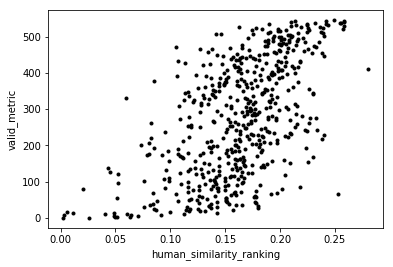

SpearmanrResult(correlation=0.5766599612864189, pvalue=1.036782225500684e-49)


In [9]:
list_human_similarity_ranking = combine_human_comparison_metrics(list_human_comparison_dict,
                                                                 experiment_keys=['bernox2005'])

plt.figure()
plt.plot(list_valid_metric, list_human_similarity_ranking, 'k.')
plt.ylabel('valid_metric')
plt.xlabel('human_similarity_ranking')
plt.show()

import scipy.stats
print(scipy.stats.spearmanr(list_valid_metric, list_human_similarity_ranking))

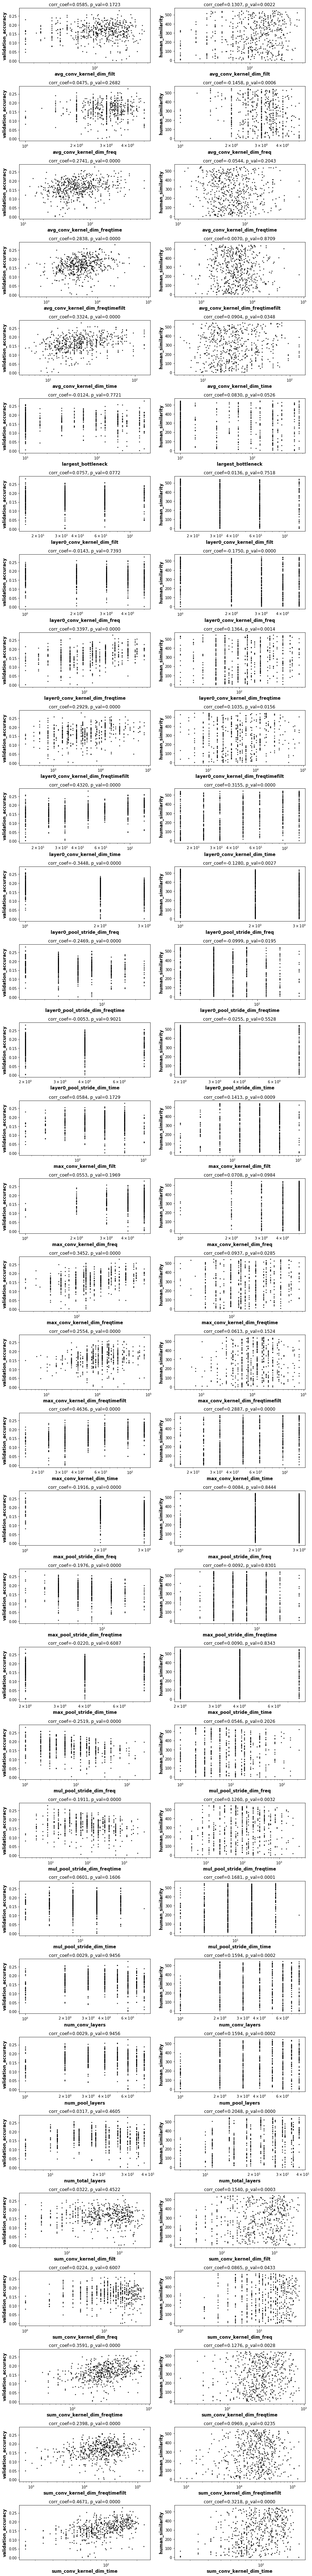

In [7]:
list_human_similarity_ranking = combine_human_comparison_metrics(list_human_comparison_dict,
                                                                 experiment_keys=['bernox2005'])
list_arch_stat_dict = {}
for idx, arch_dict in enumerate(list_arch_dict):
    arch_stats = compute_architecture_stats(arch_dict)
    if idx == 0:
        for key in arch_stats.keys():
            list_arch_stat_dict[key] = []
    for key in list_arch_stat_dict.keys():
        list_arch_stat_dict[key].append(arch_stats[key])
        

NCOLS = 2
NROWS = len(list_arch_stat_dict.keys())
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(6*NCOLS, 3*NROWS))

plot_kwargs = {'marker':'.', 'ms':3, 'ls':'', 'color':'k'}
fontsize = 12

correlation_fcn = lambda x1, x2: list(scipy.stats.spearmanr(x1, x2))

for ridx, arch_stat_key in enumerate(sorted(list_arch_stat_dict.keys())):
    xval_name, xval = (arch_stat_key, list_arch_stat_dict[arch_stat_key])
    yval_name_pair_list = [
        ('validation_accuracy', list_valid_metric),
        ('human_similarity', list_human_similarity_ranking),
    ]
    
    for cidx, (yval_name, yval) in enumerate(yval_name_pair_list):
        
        ax[ridx, cidx].plot(xval, yval, **plot_kwargs)
        corr_coef, p_val = correlation_fcn(xval, yval)
        title_str = 'corr_coef={:.4f}, p_val={:.4f}'.format(corr_coef, p_val)
        ax[ridx, cidx].set_title(title_str, fontsize=fontsize)
        ax[ridx, cidx].set_xlabel(xval_name, fontsize=fontsize, fontweight='bold')
        ax[ridx, cidx].set_ylabel(yval_name, fontsize=fontsize, fontweight='bold')
        ax[ridx, cidx].set_xscale('log')


plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_05_archSearch00_parameterAnalysis/'
# fig.savefig(os.path.join(save_dir, '2019OCT03_arch_search_v00_archStat_vs_validAccAndHumanSimilarity_onlyBernox2005.pdf'), bbox_inches='tight')


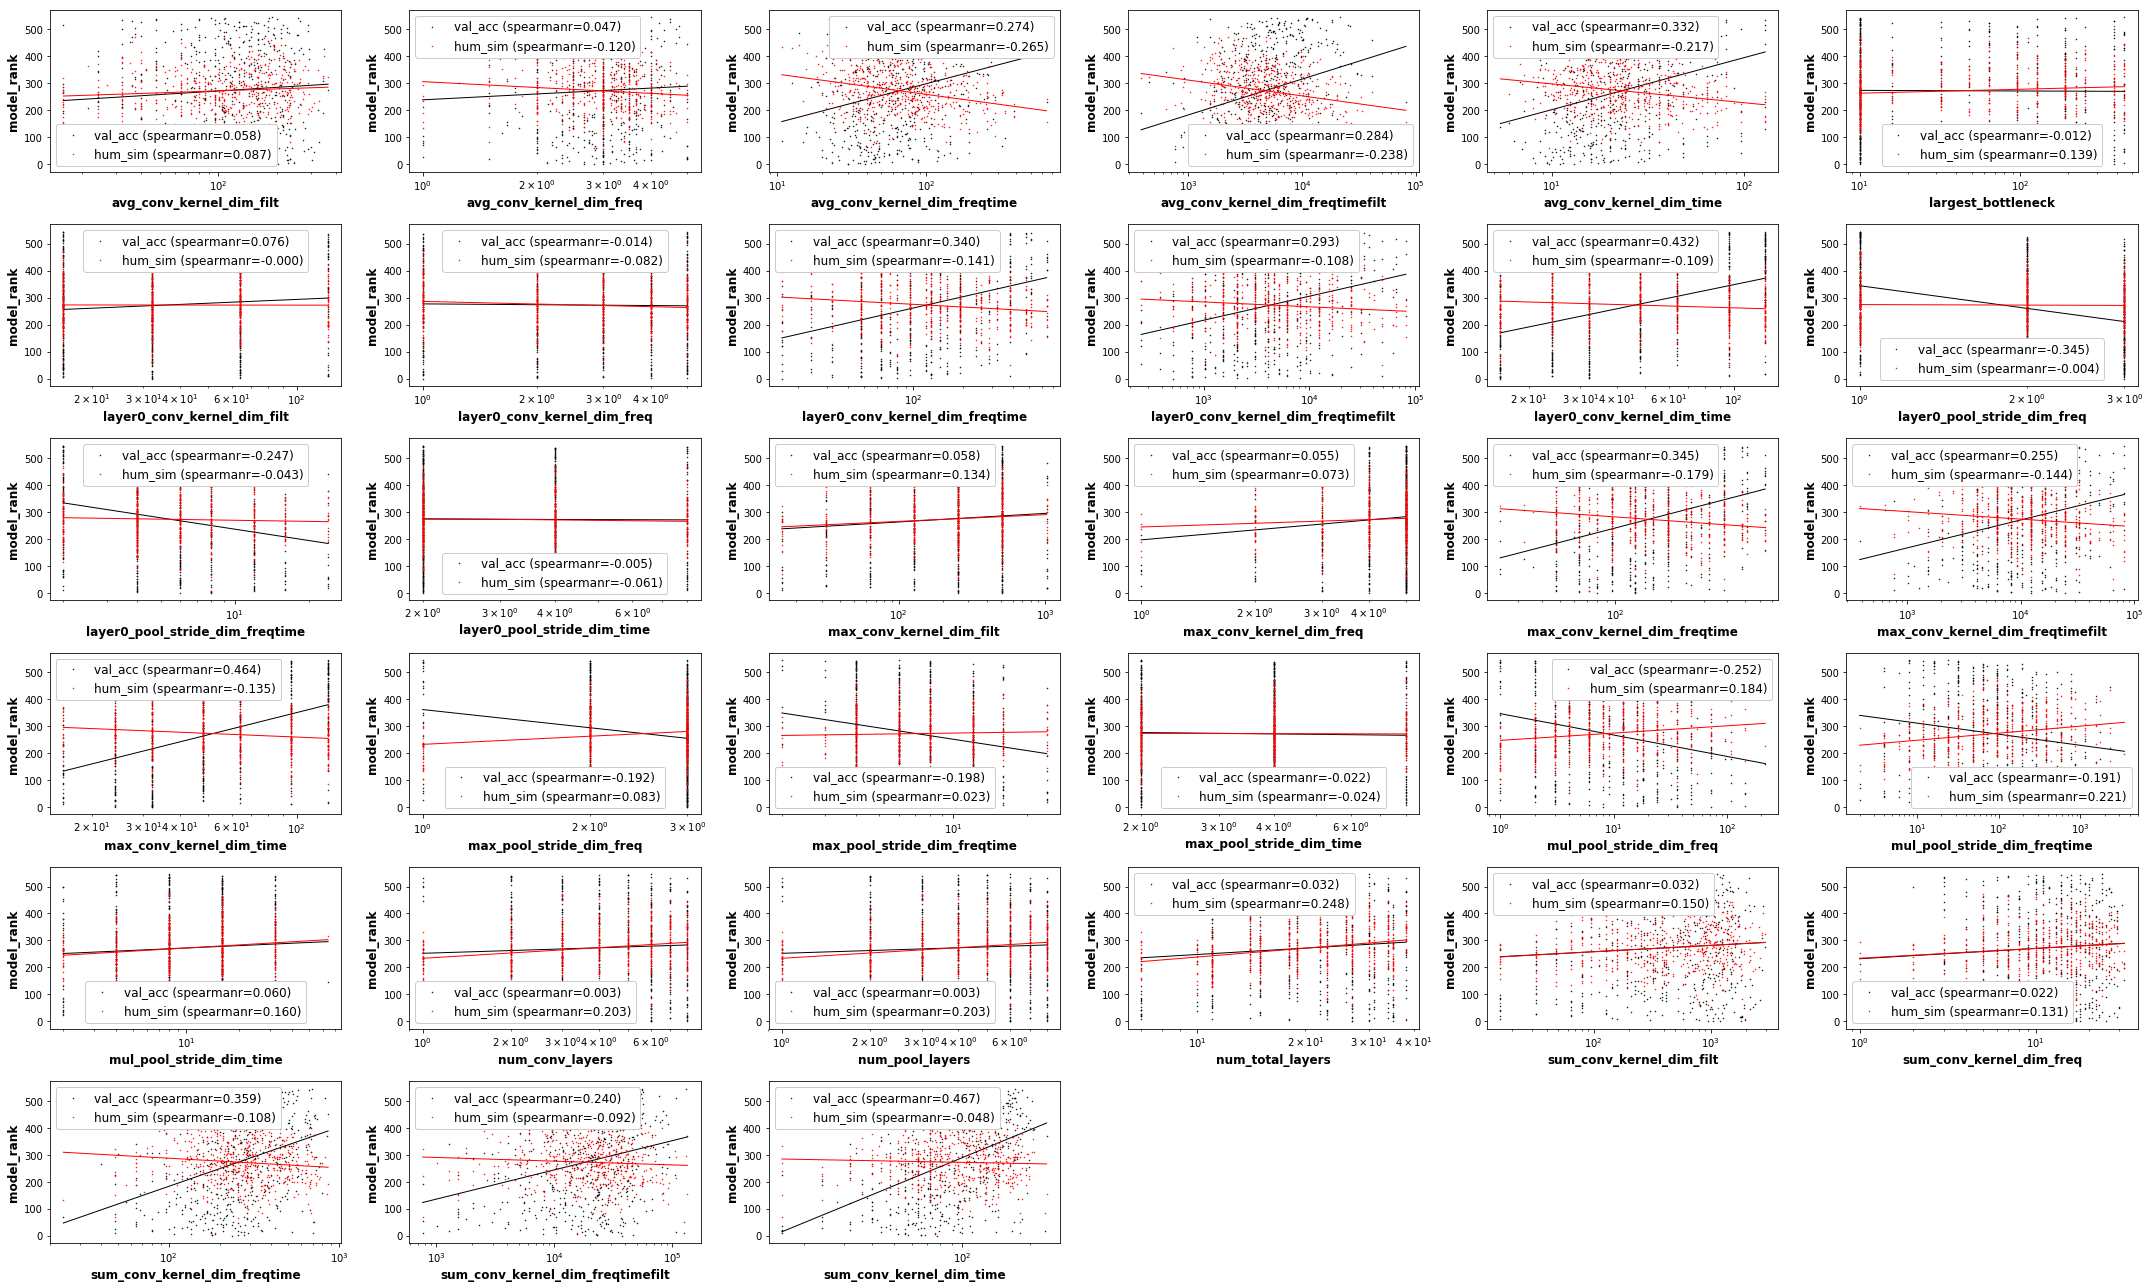

In [9]:
list_human_similarity_ranking = combine_human_comparison_metrics(list_human_comparison_dict,
                                                                 experiment_keys=None)#['bernox2005'])
list_valid_metric_ranking = np.argsort(np.argsort(list_valid_metric))

list_arch_stat_dict = {}
for idx, arch_dict in enumerate(list_arch_dict):
    arch_stats = compute_architecture_stats(arch_dict)
    if idx == 0:
        for key in arch_stats.keys():
            list_arch_stat_dict[key] = []
    for key in list_arch_stat_dict.keys():
        list_arch_stat_dict[key].append(arch_stats[key])
        

NCOLS = 6
NROWS = int(np.ceil(len(list_arch_stat_dict.keys()) / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(5*NCOLS, 3*NROWS))
ax = ax.flatten()

plot_kwargs = {'marker':'.', 'ms':1, 'ls':''}
fontsize = 12

correlation_fcn = lambda x1, x2: list(scipy.stats.spearmanr(x1, x2))
use_log_scale = True

for ax_idx, arch_stat_key in enumerate(sorted(list_arch_stat_dict.keys())):
    xval_name, xval = (arch_stat_key, list_arch_stat_dict[arch_stat_key])
    yval_name_color_list = [
        ('val_acc', list_valid_metric_ranking, 'k'),
        ('hum_sim', list_human_similarity_ranking, 'r'),
    ]
    
    for (yval_name, yval, ycolor) in yval_name_color_list:
        corr_coef, p_val = correlation_fcn(xval, yval)
        label = '{:s} (spearmanr={:.3f})'.format(yval_name, corr_coef)
        ax[ax_idx].plot(xval, yval, color=ycolor, label=label, **plot_kwargs)
        
        
        fit_xval = np.unique(xval)
        if use_log_scale:
            fit_yval = np.poly1d(np.polyfit(np.log(xval), yval, 1))(np.log(fit_xval))
        else:
            fit_yval = np.poly1d(np.polyfit(xval, yval, 1))(fit_yval)
        
        ax[ax_idx].plot(fit_xval, fit_yval, color=ycolor, ls='-', lw=1, ms=0)
        
    ax[ax_idx].set_xlabel(xval_name, fontsize=fontsize, fontweight='bold')
    ax[ax_idx].set_ylabel('model_rank', fontsize=fontsize, fontweight='bold')
    if use_log_scale: ax[ax_idx].set_xscale('log')
    ax[ax_idx].legend(loc='best', frameon=True, fontsize=fontsize, framealpha=1)

for idx in range(len(list_arch_stat_dict.keys()), len(ax)): ax[idx].axis('off')

plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_05_archSearch00_parameterAnalysis/'
# fig.savefig(os.path.join(save_dir, '2019OCT03_arch_search_v00_archStat_vs_validAccAndHumanSimilarity_allPsychophysicalTasks.pdf'), bbox_inches='tight')


In [7]:
tmp_fn = '/om2/user/msaddler/pitchnet/saved_models/PND_v04_TLAS_classification0/EVAL_SOFTMAX_AltPhase_v01_bestckpt.json'
import json
with open(tmp_fn) as f:
    rd = json.load(f)

for key in rd.keys():
    if isinstance(rd[key], str):
        print(key, rd[key])
        

tfrecords_regex /om/user/msaddler/data_pitchnet/shackcarl1994/AltPhase_v01_f0min080_f0max320/cf100_species002_spont070/*.tfrecords
out_ckpt_loc_brain_net /saved_models/PND_v04_TLAS_classification0/brain_model.ckpt
f0_label:probs_out EVAL_SOFTMAX_AltPhase_v01_bestckpt_f0_label_probs_out.npy


In [10]:
f0 = 100
octave_range = [-1, 1]
f0_prior_range = f0 * np.power(2, np.array(octave_range, dtype=float))
f0_prior_range

array([ 50., 200.])

In [15]:
bins = np.arange(90, 1000, 7.5)
bins.shape

bin_idx = np.logical_and(bins >= f0_prior_range[0], bins <= f0_prior_range[1])

print(bins[bin_idx])


[ 90.   97.5 105.  112.5 120.  127.5 135.  142.5 150.  157.5 165.  172.5
 180.  187.5 195. ]


In [17]:
bin_idx.astype(float)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])